<font style="font-size: 3rem; color: darkviolet"> MobileNets and Transfer Learning </font> 

AA - DEL - 2023/24 - TP3 - 3h

Author: Francesca Galassi

This assignment is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.

**Submit this notebook with your solutions, answers and observations.**

In this assignment, your task is to employ transfer learning on a pre-trained Convolutional Neural Network, MobileNetV2, to construct an Alpaca/Not Alpaca classifier. 

MobileNetV2 has already undergone training on the large ImageNet dataset, containing over 14 million images and 1000 classes. 

Your task is to adapt MobileNetV2 to your specific classification problem: distinguishing between alpacas and other images.

#### Main objectives:

- Augment the training dataset to increase its diversity and improve model generalization.
- Adapt the pre-trained MobileNetV2 model to the new dataset and classification task of distinguishing between alpacas and other images.
- Fine-tune the layers of the classifier to further improve the accuracy of the model.

Reminder: 

- *Epoch*: One complete pass through the entire training dataset. During an epoch, the model learns from all training examples exactly once.

- *Batch*: A subset of the training dataset processed in one forward pass and one backward pass. Weights are updated after processing each batch.

- *Iterations*: The process of updating the weights based on the gradients computed from one batch of data. One iteration is completed when a batch of data has been processed.

- *Training Steps*: The total number of steps to complete one epoch, equal to the total number of training examples divided by the batch size.

- *Optimizer*: An algorithm used to minimize the loss function by updating the weights of the neural network during training. Common optimizers include Stochastic Gradient Descent (SGD), Adam, RMSprop, and Adagrad. Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

### Table of Contents
- [1 - Dataset Preparation and Data Augmentation](#1)
- [2 - Using MobileNetV2 for Transfer Learning](#2)
    - [2.1 - Training the top layers](#2.1)
    - [2.2 - Fine-tuning the model](#2.2)

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
np.random.seed(1)

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset Preparation and Data Augmentation

<a name='1'></a>
### <font color='blue'> Exercise 1 
    
(i.) Data augmentation involves applying transformations to existing training samples to increase dataset diversity, thereby improving model generalization and performance. You apply augmentation techniques such as rotation, shifting, and flipping to the training set using `tf.keras.preprocessing.image.ImageDataGenerator`. This generator creates augmented images on-the-fly during training. 
    
To use `tf.keras.preprocessing.image.ImageDataGenerator`:
1. For the training dataset, initialize the `ImageDataGenerator` with augmentation parameters, such as rotation* and flipping**, while for the validation dataset, initialize it only for loading images and rescaling them without any augmentation. 
2. Use the `flow_from_directory()` method to generate augmented images from the directory containing the dataset. This method creates an iterator that yields batches of images and their corresponding labels. Specify the path to the dataset directory, target image size, batch size, class mode, etc.
3. In Exercise 2, after defining and compiling a model, use the `fit()` method to train the model. Pass the `train_generator` and `val_generator` objects as arguments. This way, the generators handle the data loading and augmentation on-the-fly during training.
    
Consult the official documentation for `tf.keras.preprocessing.image.ImageDataGenerator` for guidance on its usage and available parameters:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator    
    

*Note*: Ensuring the use of the same `seed` guarantees consistency in the split between training and validation datasets. Also, setting `rescale=1./255` normalizes pixel values to the range [0, 1].
   
*Rotation: `rotation_range=0.2` randomly rotate images by a degree range.
    
**Flipping: `horizontal_flip=True` randomly flips images horizontally.

In [131]:
data_dir = "data/"
batch_size = 32 # batch size for training
img_size = (160, 160) # target image size for resizing
validation_split = 0.2 # validation split (20%)

train_datagen = ImageDataGenerator(
    rotation_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=validation_split,
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    seed=19,
    target_size=img_size,
    subset="training"  
)

val_datagen = ImageDataGenerator(
    rotation_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=validation_split
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    seed=19,
    target_size=img_size,
    subset="validation"
)

Found 262 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


(ii.) Explore the dimensions, size, labels, and plot a few images from the training dataset. The images are accessed directly from the generator.

Image shape per batch: (160, 160, 3)
Number of classes: 2
Class indices (labels): {'alpaca': 0, 'not alpaca': 1}
Total samples in training set: 262
Labels array shape: (262,)


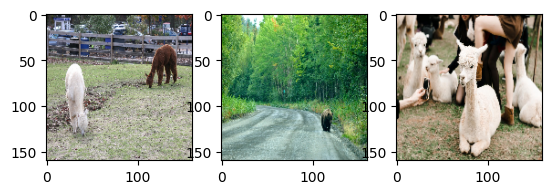

In [132]:
# TODO

print("Image shape per batch:", train_generator.image_shape)
print("Number of classes:", train_generator.num_classes)
print("Class indices (labels):", train_generator.class_indices)
print("Total samples in training set:", train_generator.samples)
print("Labels array shape:", train_generator.labels.shape)


plt.subplot(131)
plt.imshow(train_generator[0][0][0])
plt.subplot(132)
plt.imshow(train_generator[1][0][0])
plt.subplot(133)
plt.imshow(train_generator[2][0][0])


<a name='2'></a>
### <font color='darkviolet'>2 - Using MobileNetV2 for Transfer Learning

In transfer learning, we leverage the knowledge learned by a model on a large dataset and apply it to a new, possibly smaller dataset. 
    
MobileNetV2 (refer to the last lecture) was trained on the ImageNet dataset for the task of image classification. ImageNet is a widely used dataset for image classification tasks, containing millions of images across thousands of categories. 
This pre-trained model serves as a starting point for transfer learning on the similar task of binary image classification on the Alpaca dataset.

*Note*: Since MobileNetV2 was trained with normalization values in the range of [-1, 1], it's best to normalize your input data similarly. You may achieve this easily by using the `tf.keras.applications.mobilenet_v2.preprocess_input` function along with the data generator from the previous exercise.
    
Let's obtain the pre-trained MobileNetV2 model with weights learned from the ImageNet dataset and examine its architecture:

In [133]:
# Load MobileNetV2 
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=True, weights='imagenet')

# Observe the architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

*Note*: The include_top=True argument includes the fully connected layers (top layers) of the MobileNetV2 model, which are designed for the original classification task on ImageNet's 1000 classes. However, for the binary classification task on the Alpaca dataset, you will need to remove these top layers and add your own classification layer.

<a name='2.1'></a>
### <font color='blue'> Exercise 2.1 - Training the top layers only
    
(i.) Adapting the pre-trained model for the targeted task of recognizing alpacas involves the following steps:

1. Remove the top layers used for the original classification task.
2. Add a new classification layer specifically designed for the task of recognizing alpacas. This new layer will have the appropriate number of output units for binary classification.
3. Freeze the base model to ensure that the existing weights remain unchanged. This allows only training on the newly introduced layers. The frozen layers act as a feature extractor, and the training process focuses on the top layers for the specific task.
    
Consult the documentation : https://keras.io/guides/transfer_learning/#introduction

In [134]:
# 1. Load MobileNetV2 
model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

In [135]:
# 2. Create a new model with the MobileNetV2 base and a new classification layer
model_alpaca = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=2, activation="sigmoid"),
])

In [136]:
# 3. Freeze the base model
model.trainable = False

# Compile the model
model_alpaca.compile(loss=tf.losses.binary_crossentropy,metrics=["accuracy"])

(ii.) Train the model. Plot and observe the training and validation accuracy.

In [137]:
# TODO

history = model_alpaca.fit(train_generator,epochs=10,validation_data=val_generator)

/Users/tomchauvel/GitHub/2024-2025-ESIR-AA/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.6489 - loss: 0.6770 - val_accuracy: 0.8769 - val_loss: 0.4047
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9193 - loss: 0.4183 - val_accuracy: 0.9231 - val_loss: 0.3261
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9254 - loss: 0.3355 - val_accuracy: 0.9538 - val_loss: 0.2657
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9374 - loss: 0.2711 - val_accuracy: 0.9692 - val_loss: 0.2340
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.9484 - loss: 0.2331 - val_accuracy: 0.9538 - val_loss: 0.2099
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9672 - loss: 0.2036 - val_accuracy: 0.9692 - val_loss: 0.1850
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.9769 - loss: 0.1619 - val_accuracy: 0.9538 - val_loss: 0.1747
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.9706 - loss: 0.1546 - val_accuracy: 0.9385 - val_loss:

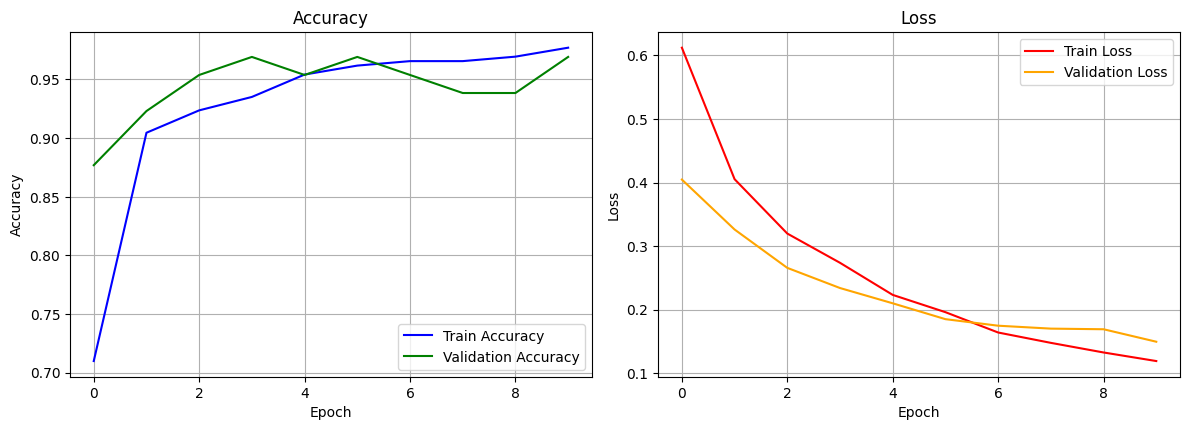

In [138]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

<a name='2.2'></a>
### <font color='blue'> Exercise 2.2 - Fine-tuning the model

In fine-tuning, we adjust the parameters of the pre-trained model to better fit the specifics of the new dataset and task. Since the pre-trained weights are already quite good, we usually use a small learning rate to make smaller adjustments to the weights during training.

Typically, the early layers of the model capture more generic features (like edges and textures) that are useful across different tasks, while later layers are more specific to the task at hand, such as distinguishing alpacas based on distinctive features like pointy ears and hairy tails.

(i.) To initiate the fine-tuning process, unfreeze the layers at the end of the network. Specify the layer from which fine-tuning begins and re-freeze all preceding layers. Re-run the training for additional epochs and assess whether this fine-tuning improves the model's accuracy. Feel free to experiment with the starting layer for fine-tuning, as the specific choice is somewhat arbitrary.

In [139]:
# TODO
model_alpaca.Trainable = True

model_alpaca.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["accuracy"])

(ii.) Fine-tune the model for additional epochs. Plot and observe the training and validation accuracy.

In [140]:
model_alpaca.fit(train_generator, epochs=20, validation_data=val_generator)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.9672 - loss: 0.1077 - val_accuracy: 0.9538 - val_loss: 0.1461
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.9675 - loss: 0.1095 - val_accuracy: 0.9692 - val_loss: 0.1322
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.9904 - loss: 0.0925 - val_accuracy: 0.9692 - val_loss: 0.1527
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.9789 - loss: 0.1036 - val_accuracy: 0.9538 - val_loss: 0.1392
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.9804 - loss: 0.1027 - val_accuracy: 0.9538 - val_loss: 0.1256
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.9778 - loss: 0.1063 - val_accuracy: 0.9538 - val_loss: 0.1490
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9865 - loss: 0.0977 - val_accuracy: 0.9692 - val_loss: 0.1369
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9864 - loss: 0.0981 - val_accuracy: 0.9385 - val_loss:

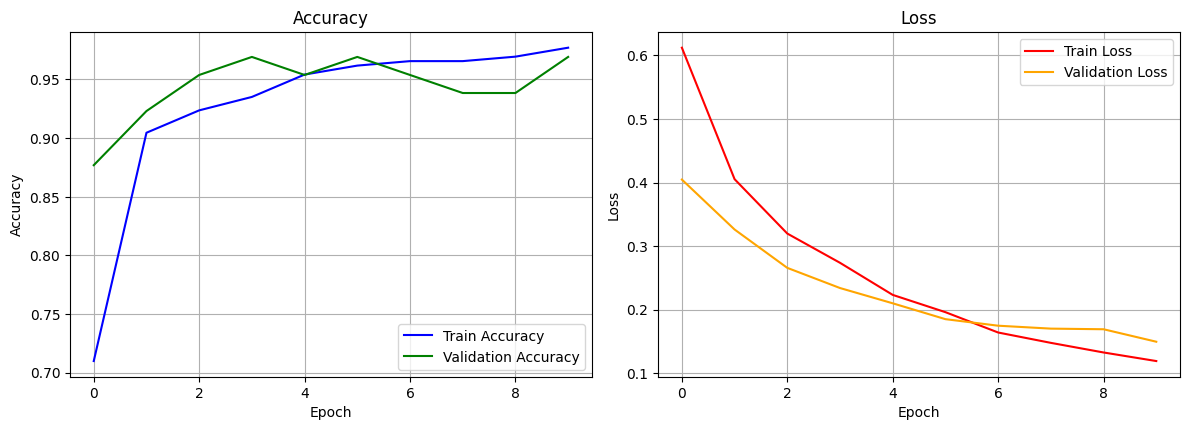

In [141]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Experiment with different strategies for data augmentation, fine-tuning, and custom layers.**